In [1]:
import pandas

from bessie.backtests import BacktestInputData, run_backtest, BatterySpec
from bessie.core import Region
from bessie.strategies import (
    ForecastBaseline,
    QuantilePicker,
    ClarabelOptimised,
)
from bessie import analysis
import plotly.graph_objects as go


start = pandas.Timestamp("2022-01-01 00:00:00")
end = pandas.Timestamp("2022-02-01 00:00:00")

battery = BatterySpec(
    e_max=50,
    p_max=50,
    deg=0.00001,
    eta_chg=0.9,
    eta_dchg=0.95,
)
data = BacktestInputData.from_aemo_forecasts(
    start=start,
    end=end,
    region=Region.NSW,
)
strategies = [
    ForecastBaseline(50, 75),
    QuantilePicker(0.1, 0.9),
    # ClarabelOptimised(gamma=20, horizon=12 * 3),
]

2026-02-18 16:10:25,391 - INFO - root - Loading cached file: /data/xarray_cache/bessie/data/bronze/_predispatch/_get_predispatch_price_single/year=2022month=1.netcdf
2026-02-18 16:10:25,524 - INFO - root - Loading cached file: /data/xarray_cache/bessie/data/bronze/_predispatch/_get_predispatch_price_single/year=2022month=2.netcdf
2026-02-18 16:10:25,610 - INFO - root - Loading cached file: /data/xarray_cache/bessie/data/bronze/_p5min/_get_p5min_price_single/year=2022month=1.netcdf
2026-02-18 16:10:25,618 - INFO - root - Loading cached file: /data/xarray_cache/bessie/data/bronze/_p5min/_get_p5min_price_single/year=2022month=2.netcdf
2026-02-18 16:10:25,632 - INFO - root - nemosis query start: 2022/01/01 00:00:00
2026-02-18 16:10:25,633 - INFO - root - nemosis query end: 2022/02/01 00:00:00
2026-02-18 16:10:25,633 - INFO - nemosis.data_fetch_methods - Compiling data for table DISPATCHPRICE
2026-02-18 16:10:25,924 - INFO - nemosis.data_fetch_methods - Returning DISPATCHPRICE.


In [2]:
results = [run_backtest(data, battery, strat) for strat in strategies]

2026-02-18 16:10:26,032 - INFO - root - Running BESS backtest (njit) for strategy ForecastBaseline
2026-02-18 16:10:26,554 - INFO - root - Running BESS backtest (njit) for strategy QuantilePicker


In [3]:
analysis.backtest_scorecard(data, battery, results)

Region:            NSW1
Energy capacity:   50 MWh
Power rating:      50 MW
Duration:          1.0 H
Degredation rate:  0.001000%
η (charge):        90.0%
η (discharge):     95.0%
N. Days:           31


ForecastBaseline QuantilePicker
Revenue     Total                           $6,022        $31,219
            Per day                           $194         $1,007
Activity    Charging intervals                  48            231
            Charging %                        0.5%           2.6%
            Idle intervals                   8,840          8,044
            Idle %                           99.0%          90.1%
            Discharging intervals               40            653
            Discharging %                     0.4%           7.3%
Degradation Total actions                       88            884
            Actions per day                    2.8           28.5
            Final capacity (MWh)             49.96          49.56
            Capacity remaining %            99.91%         99.12%

2026-02-18 16:10:27,477 - INFO - choreographer.browsers.chromium - Chromium init'ed with kwargs {}
2026-02-18 16:10:27,478 - INFO - choreographer.browsers.chromium - Found chromium path: /app/.venv/lib/python3.12/site-packages/choreographer/cli/browser_exe/chrome-linux64/chrome
2026-02-18 16:10:27,479 - INFO - choreographer.utils._tmpfile - Temp directory created: /tmp/tmp4z_0jl3t.
2026-02-18 16:10:27,479 - INFO - choreographer.browser_async - Opening browser.
2026-02-18 16:10:27,480 - INFO - choreographer.utils._tmpfile - Temp directory created: /tmp/tmp02bh75ml.
2026-02-18 16:10:27,508 - INFO - choreographer.browsers.chromium - Temporary directory at: /tmp/tmp02bh75ml
2026-02-18 16:10:27,761 - INFO - kaleido.kaleido - Conforming 1 to file:///tmp/tmp4z_0jl3t/index.html
2026-02-18 16:10:27,763 - INFO - kaleido.kaleido - Waiting on all navigates
2026-02-18 16:10:29,123 - INFO - kaleido.kaleido - All navigates done, putting them all in queue.
2026-02-18 16:10:29,125 - INFO - kaleido.kale

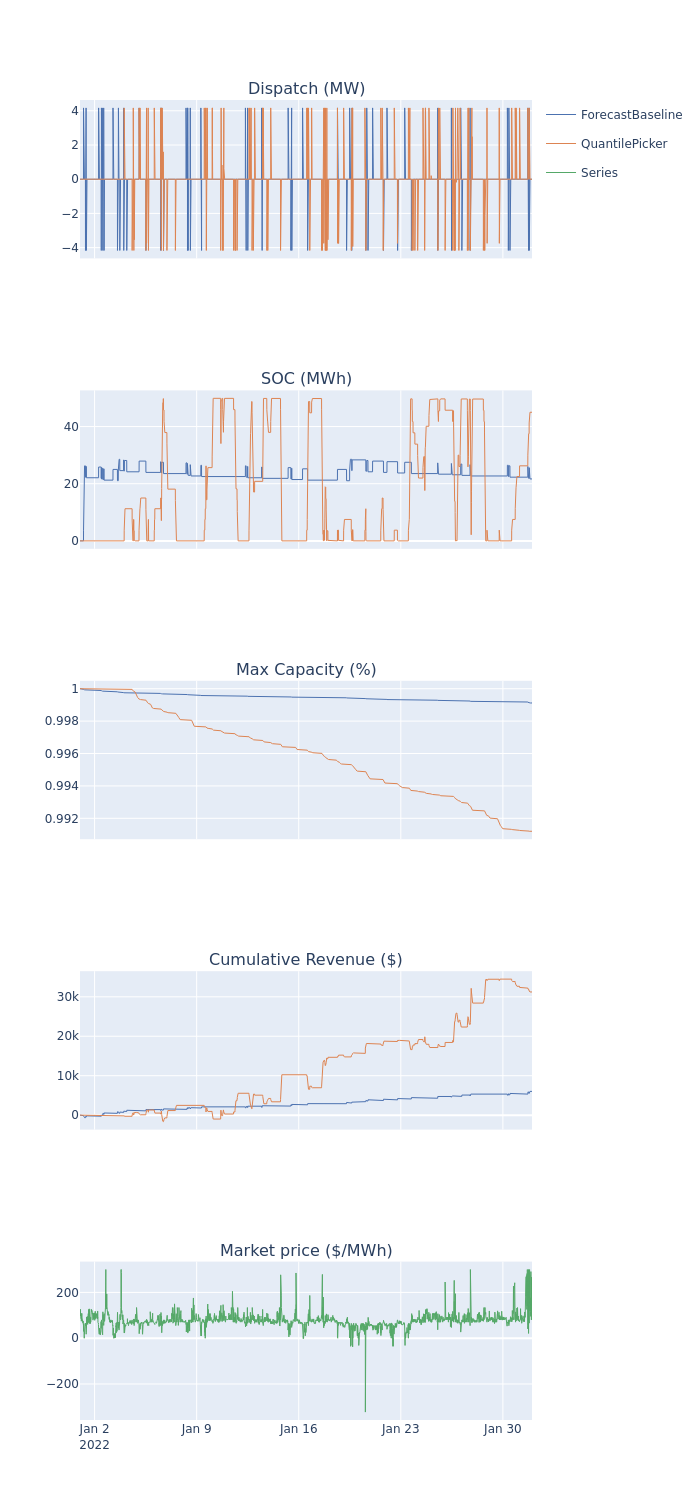

In [4]:
analysis.backtest_comparison(data, battery, results, resampler=False).show("png")